# Pipeline:


### -Lectura del Dataset original. [path dataset Original]

### -Agregar Features [numero de features mas representativos a incluir]
### -Agregar Clasificacion [valores para separar]


In [1]:
import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import os, glob

import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import xgboost as xgb
import numpy as np
import collections
import witwidget
import os, glob


from matplotlib import pyplot
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
#plots
import seaborn as sns

from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
    
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder


from backtesting import Backtest, Strategy
from backtesting.lib import crossover, SignalStrategy, TrailingStrategy, resample_apply
from backtesting.test import SMA
from backtesting import Backtest
#plots
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd 
import math as m
import os, glob

Loading BokehJS ...

In [2]:
MODEL_NAME = "XGBoost_2"
FRECUENCIA = "4H"
INDEX_TO_READ = 5
LIMITE_IZQ = [-0.0025, -.002, -.0018] #[-.002]#[-0.0029, -0.0025, -.002]
LIMITE_DER = [0.0025, .002, .0018] #[.0025]#[0.0029, 0.0025, .002]

BALANCED = True
TARGET_NAME = "Class"
PROFUNDIDAD = [1,2,3,4,5,6,7,8,9,10] #[1,2] #[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]

VAL_PCT = [.25]#[.2, .25]
TEST_PCT = [.2]#[.2, .15]


CASH = 1000
COMMISSION = 0.0001

In [3]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados-regression/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(filenames.index(file), ' ', os.path.basename(file))

0   R-EURUSD_FULL_1D_144F.csv
1   R-EURUSD_FULL_1D_44F.csv
2   R-EURUSD_FULL_1D_69F.csv
3   R-EURUSD_FULL_1H_44F.csv
4   R-EURUSD_FULL_1H_49F.csv
5   R-EURUSD_FULL_4H_144F.csv


In [4]:
def read_dataset(INDEX_TO_READ):
    if FRECUENCIA =="1D":
        dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
    else:
        dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    DATASET_FULL = pd.read_csv(filenames[INDEX_TO_READ], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
    #print(DATASET_FULL)
    #print(DATASET_FULL.shape)
    return DATASET_FULL
    
def add_target_column(DATASET_FULL, limite_izq, limite_der):
    DATASET_FULL['Class'] = 0

    DATASET_FULL.loc[DATASET_FULL['Pct_Range_Close'] <= limite_izq, 'Class'] = -1
    DATASET_FULL.loc[DATASET_FULL['Pct_Range_Close'] >= limite_der, 'Class'] = 1

    DATASET_FULL['Class'] = DATASET_FULL['Class'].shift(-1)
    DATASET_FULL['Class'].fillna(0, inplace=True)
    #print(DATASET_FULL['Class'].head(5))
    return DATASET_FULL


def remove_features(data):
    data = data.drop(['Gmt time'], axis = 1)
    data = data.drop(['day_name'], axis = 1)
    data = data.drop(['weekday'], axis = 1)
    data = data.drop(['Open_Bid'], axis = 1)
    data = data.drop(['High_Bid'], axis = 1)
    data = data.drop(['Low_Bid'], axis = 1)
    data = data.drop(['Close_Bid'], axis = 1)
    return data

def get_target_vector(data):
    labels = data['Class'].values
    data = data.drop(columns=['Class'])
    return data, labels

def get_2Dimension(df, PROFUNDIDAD):
    new_df = pd.DataFrame()
    for i in range(PROFUNDIDAD):
        for j in range (df.shape[1]):
            new_col_name = df.columns[j] + '_' + str(i+1)
            new_df[new_col_name] = df.iloc[i+1:,j]
            new_df.fillna(method='backfill', inplace=True)
    #print(new_df.columns)
    df = pd.concat([df, new_df], axis=1, sort=False)
    df.fillna(method='backfill', inplace=True)
    return df

def split_in_3(data, y_vector, val_pct, test_pct):
    total = data.shape[0]
    #print('Total: ', total)

    s1 = test_pct + val_pct
    #print('Sum of %s:',s1)
    f1 = int(total * s1)
    #print('count of Val and Test:',f1)
    end_train = total - f1
    #print('end of train: ', end_train)

    count_val= int(total * val_pct)
    #print('count val: ',count_val)

    count_test= int(total * test_pct)
    #print('count test: ',count_test)

    end_val = end_train + count_val
    #print('end_val', end_val)

    x_train = data.iloc[:end_train]
    x_val = data.iloc[end_train: end_val]
    x_val.reset_index(drop=True, inplace=True)
    x_test = data.iloc[end_val:]
    x_test.reset_index(drop=True, inplace=True)

    #print("x_train.shape: ",x_train.shape)
    #print("x_val.shape: ", x_val.shape)
    #print("x_test.shape: ", x_test.shape)

    y_train = y_vector[:end_train]
    y_val = y_vector[end_train: end_val]
    y_test = y_vector[end_val:]

    #print("y_train.shape: ", y_train.shape)
    #print("y_val.shape: ", y_val.shape)
    #print("y_test.shape: ", y_test.shape)

    
    return x_train, x_val, x_test, y_train, y_val, y_test

def get_train_resampling(x_train, y_train):
    target = pd.DataFrame(y_train, columns = ["target"])
    x_train_target  = pd.concat([x_train, target], axis=1, sort=False)
    x_train_target['target'].value_counts()

    match_majority = x_train_target['target'].value_counts()[0]
    match_majority

    # resample for sell
    df_majority_sell = x_train_target[x_train_target.target != -1]
    df_minority_sell = x_train_target[x_train_target.target == -1]
    df_minority_sell_upsampled = resample(df_minority_sell, 
                                     replace=True,     # sample with replacement
                                     n_samples=match_majority,  # to match majority class
                                     random_state=123) # reproducible results
    df_upsampled_sell = pd.concat([df_majority_sell, df_minority_sell_upsampled])
    df_upsampled_sell['target'].value_counts()


    #resample for buy
    df_majority_buy = df_upsampled_sell[df_upsampled_sell.target != 1]
    df_minority_buy = df_upsampled_sell[df_upsampled_sell.target == 1]
    df_minority_buy_upsampled = resample(df_minority_buy, 
                                     replace=True,     # sample with replacement
                                     n_samples=match_majority,  # to match majority class
                                     random_state=123) # reproducible results
    df_upsampled  = pd.concat([df_majority_buy, df_minority_buy_upsampled])
    df_upsampled['target'].value_counts()
    labels = df_upsampled['target'].values
    df_upsampled = df_upsampled.drop(['target'], axis = 1)
    return df_upsampled, labels


def train_xgboost_model(x_train, y_train):
    # Train the model, this will take a few minutes to run
    bst = xgb.XGBClassifier(
        objective='reg:logistic'
    )

    bst.fit(x_train, y_train)
    return bst

def get_predictions(model, x_subset):
    predictions = model.predict(x_subset)
    return predictions

def get_acc(predicted, y_subset):
    acc = accuracy_score(y_subset, predicted.round())
    #print(acc, '\n')
    return acc

def print_confision_matrix(y_test, y_pred):
    print('Confusion matrix:')
    cm = confusion_matrix(y_test, y_pred.round())
    cm = cm / cm.astype(np.float).sum(axis=1)
    print(cm)
    
def get_dataset_with_pred(dataset_x, vec_y, vec_y_pred):
    y_df = pd.DataFrame({'Real_Class': vec_y})
    y_pred_df = pd.DataFrame({'Predicted_Class': vec_y_pred})
    #print('y_df ',y_df.shape)
    #print('y_pred_df ',y_pred_df.shape)
    dataset_x_vec_y = pd.concat([dataset_x,y_df], axis=1, sort=False)
    #print('dataset_x_vec_y ',dataset_x_vec_y.shape)
    dataset_x_vec_y_pred = pd.concat([dataset_x_vec_y,y_pred_df], axis=1, sort=False)
    #print('x_test ', dataset_x_vec_y_pred.shape)
    return dataset_x_vec_y_pred

def get_filepath_results():
    filename = 'BackTesting_Results.csv'
    #print(filename)
    pwd = os.getcwd()
    path_backstesting = os.path.join(pwd, r'../../../Results/pipeline/')
    filename_path_backstesting = os.path.join(pwd, r'../../../Results/pipeline/' + filename)
    #print(filename_path_backstesting)
    return filename_path_backstesting

def backtest(full_test):
    STRATEGY_NAME = limits_Pred
    bt = Backtest(full_test, STRATEGY_NAME, cash=CASH, commission=COMMISSION)#trade_on_close=False
    bt.run()
    return bt._results

In [5]:
class limits_Pred(SignalStrategy, TrailingStrategy):
    buy_lim = 0.99
    sell_lim = -0.99
    
    def init(self):
        super().init()
        self.Op_Abierta = False
        
    def next(self):
        sig = self.data.Predicted_Class[-1]
        if not self.Op_Abierta and sig >= self.buy_lim:
            self.buy()
            self.Op_Abierta = True
        if self.Op_Abierta and sig <= self.sell_lim:
            self.sell()
            self.Op_Abierta = False

In [6]:
class limits_Real(SignalStrategy, TrailingStrategy):
    buy_lim = 0.99
    sell_lim = -0.99
    
    def init(self):
        super().init()
        self.Op_Abierta = False
        
    def next(self):
        sig = self.data.Real_Class[-1]
        if not self.Op_Abierta and sig >= self.buy_lim:
            self.buy()
            self.Op_Abierta = True
        if self.Op_Abierta and sig <= self.sell_lim:
            self.sell()
            self.Op_Abierta = False

In [7]:
def pipeline_one(LIMITE_IZQ_one, LIMITE_DER_one, VAL_PCT_one, TEST_PCT_one,  PROFUNDIDAD_one):
    Dataset =  read_dataset(INDEX_TO_READ)
    Dataset_with_target = add_target_column(Dataset, LIMITE_IZQ_one, LIMITE_DER_one)
    Dataset_remove_features = remove_features(Dataset_with_target)

    SIZE = Dataset_remove_features.shape[0]
    NUM_FEATURES = Dataset_remove_features.shape[1]

    Data_without_target, Data_target = get_target_vector(Dataset_remove_features)

    Dataset_in_2d =  get_2Dimension(Data_without_target, PROFUNDIDAD_one)

    x_train, x_val, x_test, y_train, y_val, y_test = split_in_3(Dataset_in_2d, Data_target, VAL_PCT_one, TEST_PCT_one)
    #Resample Balance 
    if (BALANCED):
        x_train, y_train = get_train_resampling(x_train, y_train)
    
    #Shuffle x_train 
    
    model = train_xgboost_model(x_train, y_train)


    test_predictions =  get_predictions(model, x_test)
    ACC_TEST = get_acc (test_predictions, y_test)
    #print_confision_matrix(y_test, test_predictions)

    val_predictions =  get_predictions(model, x_val)
    ACC_VAL = get_acc (val_predictions, y_val)
    #print_confision_matrix(y_val, val_predictions)

    full_test =  get_dataset_with_pred(x_test, y_test, test_predictions)
    full_val =  get_dataset_with_pred(x_val, y_val, val_predictions)
    filepath_results = get_filepath_results()
    bt_pred = backtest(full_test)

    data_results = {'Model_Name':[MODEL_NAME], 
                    'FRECUENCIA':[FRECUENCIA], 
                    'LIMITE_IZQ':[LIMITE_IZQ_one], 
                    'LIMITE_DER':[LIMITE_DER_one],
                    'PROFUNDIDAD':[PROFUNDIDAD_one],
                    'BALANCED':[BALANCED],
                    'VAL_PCT':[VAL_PCT_one], 
                    'TEST_PCT':[TEST_PCT_one], 
                    'ACC_TEST':[ACC_TEST],
                    'ACC_VAL':[ACC_VAL],
                    'Duration':[bt_pred['Duration']],
                    'Exposure':[bt_pred['Exposure [%]']],
                    'Buy & Hold Return [%]':[bt_pred['Buy & Hold Return [%]']],
                    '_strategy':[bt_pred['_strategy']],                
                    'Pred_Equity_Final_$':[bt_pred['Equity Final [$]']], 
                    'Pred_Equity_Peak_$':[bt_pred['Equity Peak [$]']], 
                    'Pred_Return_%':[bt_pred['Return [%]']], 
                    'Pred_#_Trades':[bt_pred['# Trades']], 
                    'Pred_Win_Rate':[bt_pred['Win Rate [%]']],
                    'Commission':[COMMISSION],
                    'Cash':[CASH]}
    Results = pd.DataFrame(data_results)
    print('Equity Final [$]: ',bt_pred['Equity Final [$]'])

    Results_loaded = pd.read_csv(filepath_results, header=0)
    Results_loaded = Results_loaded.append(Results,ignore_index=True)

    Results_loaded.to_csv(filepath_results, header=True, index=False)
    return Results_loaded

In [8]:
for k in range(len(LIMITE_IZQ)):
    lim_izq = LIMITE_IZQ[k]
    print('LIMITE_IZQ: ', lim_izq)
    for o in range(len(LIMITE_DER)):
        lim_der = LIMITE_DER[o]
        print('   LIMITE_DER: ', lim_der)
        for i in range(len(PROFUNDIDAD)):
            prof_one = PROFUNDIDAD[i]
            print('      PROFUNDIDAD: ', prof_one)
            for j in range(len(VAL_PCT)):
                val_pct_one = VAL_PCT[j]
                print('         VAL_PCT: ', val_pct_one)
                for jj in range(len(TEST_PCT)):
                    test_pct_one = TEST_PCT[jj]
                    print('            TEST_PCT: ', test_pct_one)
                    pipeline_one(lim_izq, lim_der, val_pct_one, test_pct_one, prof_one)

LIMITE_IZQ:  -0.0025
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  1
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  1097.4515819010148
      PROFUNDIDAD:  2
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  1126.3382658992148
      PROFUNDIDAD:  3
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  1158.2797715438144
      PROFUNDIDAD:  4
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  1064.1755837687501
      PROFUNDIDAD:  5
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  1011.8980520343239
      PROFUNDIDAD:  6
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  1046.1793987516555
      PROFUNDIDAD:  7
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  1051.1668026962982
      PROFUNDIDAD:  8
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  951.7459356093945
      PROFUNDIDAD:  9
         VAL_PCT:  0.25
            TEST_PCT:  

Equity Final [$]:  828.4950031145727
      PROFUNDIDAD:  4
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  1003.0704949965685
      PROFUNDIDAD:  5
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  949.3472011148556
      PROFUNDIDAD:  6
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  935.4386095587545
      PROFUNDIDAD:  7
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  925.3695351389271
      PROFUNDIDAD:  8
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  1070.3880212023653
      PROFUNDIDAD:  9
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  1046.002661302289
      PROFUNDIDAD:  10
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  1014.8961935893583
   LIMITE_DER:  0.0018
      PROFUNDIDAD:  1
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  786.0208907948339
      PROFUNDIDAD:  2
         VAL_PCT:  0.25
          

In [11]:
filepath_results = get_filepath_results()
Results_loaded = pd.read_csv(filepath_results, header=0)
this_model = Results_loaded.loc[Results_loaded['Model_Name'] == MODEL_NAME]
this_model

,Model_Name,FRECUENCIA,LIMITE_IZQ,LIMITE_DER,PROFUNDIDAD,BALANCED,VAL_PCT,TEST_PCT,ACC_TEST,ACC_VAL,...,Exposure,Buy & Hold Return [%],_strategy,Pred_Equity_Final_$,Pred_Equity_Peak_$,Pred_Return_%,Pred_#_Trades,Pred_Win_Rate,Commission,Cash
97,XGBoost_2,4H,-0.0025,0.0025,1,True,0.25,0.2,0.826948,0.783935,...,94.167610,4.583859,limits_Pred,1097.451582,1218.786517,9.745158,106.0,47.169811,0.0001,1000
98,XGBoost_2,4H,-0.0025,0.0025,2,True,0.25,0.2,0.714097,0.712366,...,99.660249,4.583859,limits_Pred,1126.338266,1128.721631,12.633827,340.0,55.882353,0.0001,1000
99,XGBoost_2,4H,-0.0025,0.0025,3,True,0.25,0.2,0.590489,0.615280,...,99.622499,4.583859,limits_Pred,1158.279772,1175.586148,15.827977,528.0,57.765152,0.0001,1000
100,XGBoost_2,4H,-0.0025,0.0025,4,True,0.25,0.2,0.722967,0.772158,...,94.620612,4.583859,limits_Pred,1064.175584,1215.007831,6.417558,118.0,58.474576,0.0001,1000
101,XGBoost_2,4H,-0.0025,0.0025,5,True,0.25,0.2,0.706548,0.717953,...,99.584749,4.583859,limits_Pred,1011.898052,1124.536349,1.189805,234.0,48.717949,0.0001,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,XGBoost_2,4H,-0.0018,0.0018,6,True,0.25,0.2,0.321948,0.466858,...,99.830125,4.583859,limits_Pred,807.814149,1048.514151,-19.218585,1089.0,45.913682,0.0001,1000
183,XGBoost_2,4H,-0.0018,0.0018,7,True,0.25,0.2,0.559162,0.576023,...,99.018498,4.583859,limits_Pred,1059.150531,1136.003457,5.915053,566.0,48.056537,0.0001,1000
184,XGBoost_2,4H,-0.0018,0.0018,8,True,0.25,0.2,0.375543,0.484675,...,99.830125,4.583859,limits_Pred,1027.160125,1142.884126,2.716013,1053.0,51.092118,0.0001,1000
185,XGBoost_2,4H,-0.0018,0.0018,9,True,0.25,0.2,0.398943,0.534954,...,99.811250,4.583859,limits_Pred,858.986802,1018.804171,-14.101320,923.0,45.828819,0.0001,1000


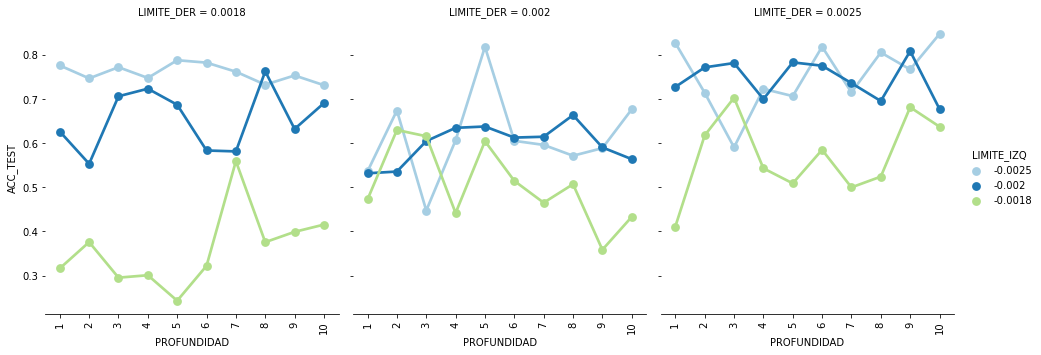

In [13]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="PROFUNDIDAD", y="ACC_TEST", hue="LIMITE_IZQ", col="LIMITE_DER",
                capsize=.2, palette="Paired", height=5, aspect=.9,
                kind="point", data=this_model)
g.set_xticklabels(rotation=90)
g.despine(left=True)

## Se observa mas estabilidad de ACC en LIMITE_DER .0018 con LIMITE_IZQ -.0025

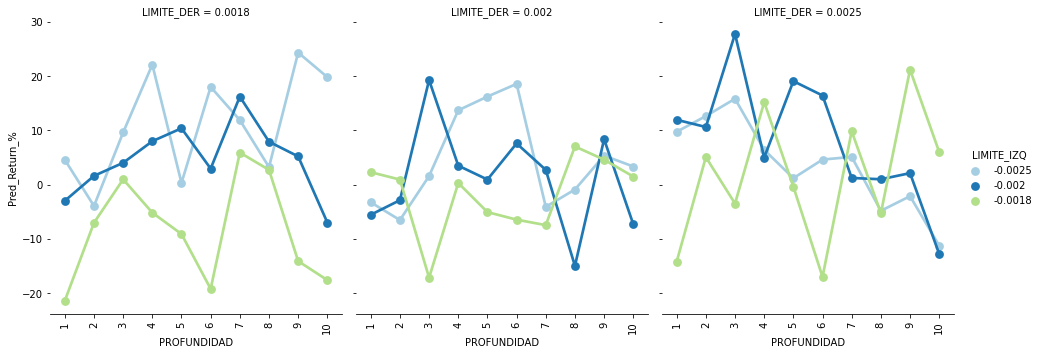

In [16]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="PROFUNDIDAD", y="Pred_Return_%", hue="LIMITE_IZQ", col="LIMITE_DER",
                capsize=.2, palette="Paired", height=5, aspect=.9,
                kind="point", data=this_model)
g.set_xticklabels(rotation=90)
g.despine(left=True)

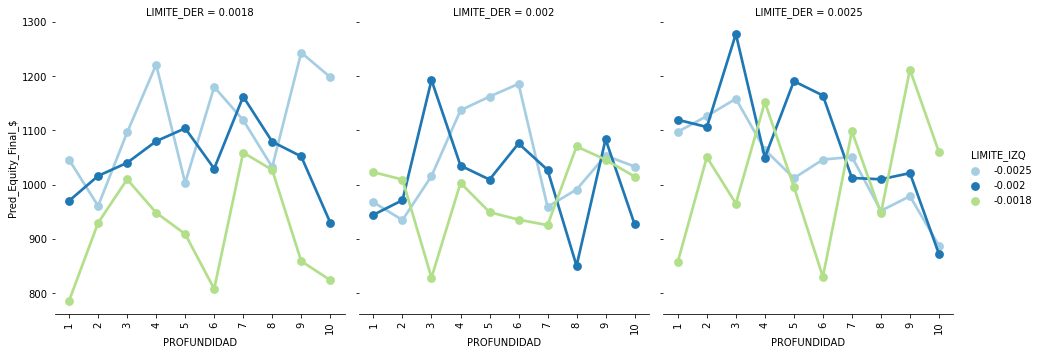

In [17]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="PROFUNDIDAD", y="Pred_Equity_Final_$", hue="LIMITE_IZQ", col="LIMITE_DER",
                capsize=.2, palette="Paired", height=5, aspect=.9,
                kind="point", data=this_model)
g.set_xticklabels(rotation=90)
g.despine(left=True)

## LIMITE_IZQ fue superior -.0025 en muchos casos. 

## LIMITE_DER con mejores ganancias en .0018 y .0025

In [18]:
winners = this_model.loc[this_model['Pred_Return_%'] >= 15]
winners

,Model_Name,FRECUENCIA,LIMITE_IZQ,LIMITE_DER,PROFUNDIDAD,BALANCED,VAL_PCT,TEST_PCT,ACC_TEST,ACC_VAL,...,Exposure,Buy & Hold Return [%],_strategy,Pred_Equity_Final_$,Pred_Equity_Peak_$,Pred_Return_%,Pred_#_Trades,Pred_Win_Rate,Commission,Cash
99,XGBoost_2,4H,-0.0025,0.0025,3,True,0.25,0.2,0.590489,0.615280,...,99.622499,4.583859,limits_Pred,1158.279772,1175.586148,15.827977,528.0,57.765152,0.0001,1000
111,XGBoost_2,4H,-0.0025,0.0020,5,True,0.25,0.2,0.818268,0.779405,...,98.263496,4.583859,limits_Pred,1162.306731,1248.689968,16.230673,73.0,57.534247,0.0001,1000
112,XGBoost_2,4H,-0.0025,0.0020,6,True,0.25,0.2,0.605209,0.638985,...,99.754624,4.583859,limits_Pred,1185.707881,1217.795977,18.570788,394.0,52.791878,0.0001,1000
120,XGBoost_2,4H,-0.0025,0.0018,4,True,0.25,0.2,0.747688,0.736222,...,98.452246,4.583859,limits_Pred,1221.267447,1273.367941,22.126745,236.0,52.542373,0.0001,1000
122,XGBoost_2,4H,-0.0025,0.0018,6,True,0.25,0.2,0.782412,0.711007,...,95.564364,4.583859,limits_Pred,1180.124039,1272.025763,18.012404,135.0,53.333333,0.0001,1000
125,XGBoost_2,4H,-0.0025,0.0018,9,True,0.25,0.2,0.753350,0.679601,...,97.904870,4.583859,limits_Pred,1243.456592,1285.942756,24.345659,203.0,56.157635,0.0001,1000
126,XGBoost_2,4H,-0.0025,0.0018,10,True,0.25,0.2,0.731270,0.703156,...,99.037373,4.583859,limits_Pred,1198.185902,1255.178349,19.818590,160.0,51.250000,0.0001,1000
129,XGBoost_2,4H,-0.0020,0.0025,3,True,0.25,0.2,0.781468,0.741658,...,99.301623,4.583859,limits_Pred,1277.703718,1292.459744,27.770372,163.0,58.282209,0.0001,1000
131,XGBoost_2,4H,-0.0020,0.0025,5,True,0.25,0.2,0.782978,0.697418,...,98.754247,4.583859,limits_Pred,1190.768762,1192.868392,19.076876,148.0,55.405405,0.0001,1000
132,XGBoost_2,4H,-0.0020,0.0025,6,True,0.25,0.2,0.775429,0.736373,...,99.358248,4.583859,limits_Pred,1164.303951,1195.267662,16.430395,168.0,59.523810,0.0001,1000


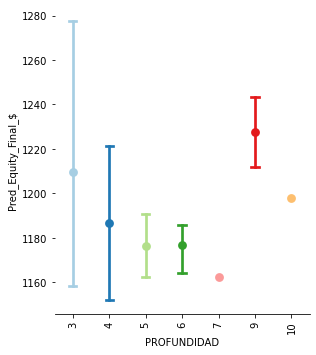

In [28]:


# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="PROFUNDIDAD", y="Pred_Equity_Final_$", hue="PROFUNDIDAD", #col="LIMITE_DER",
                capsize=.2, palette="Paired", height=5, aspect=.9,
                kind="point", data=winners)
g.set_xticklabels(rotation=90)
g.despine(left=True)

## Se identifican los valores de PROFUNDIDAD con mejor ganancia arriba de .15% de Pred Return. PROF: 3,4,5,6.